In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import re
import json

In [2]:
_bb=pd.read_csv('bkk_budget_ocr.csv',index_col=0)
_bb=_bb[~_bb['pagenum'].isna()]

/Users/napatswift/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# number of document
len(_bb.pdf.unique())

385

In [4]:
_bb['pagenum'] = _bb['pagenum'].astype(int)
_bb['text'] = _bb['text'].astype(str)

select test set

remove unwanted document (just for develop)

In [5]:
_bb

,pdf,pagenum,image_path,x0,y0,x1,y1,text,ocr-text
0,pdf/61/A20171003165836.pdf,0,A20171003165836/00.png,886.109985,218.514427,944.322144,260.634430,161,NaN
1,pdf/61/A20171003165836.pdf,0,A20171003165836/00.png,784.949982,352.531105,1045.670013,394.651108,ส/านักงานเขตบางพลัด,NaN
2,pdf/61/A20171003165836.pdf,0,A20171003165836/00.png,436.019989,474.211075,666.247696,516.331100,งบประมาณรายจ่าย,NaN
3,pdf/61/A20171003165836.pdf,0,A20171003165836/00.png,436.019989,541.621170,455.013062,583.741196,ปี,NaN
4,pdf/61/A20171003165836.pdf,0,A20171003165836/00.png,464.460022,541.621170,538.070297,583.741196,2560,NaN
...,...,...,...,...,...,...,...,...,...
1693958,pdf/65/65071.pdf,61,65071/61.png,352.500000,1624.007996,452.317520,1670.340088,07199-3,NaN
1693959,pdf/65/65071.pdf,61,65071/61.png,512.339996,1624.007996,543.382828,1670.340088,(9),NaN
1693960,pdf/65/65071.pdf,61,65071/61.png,552.300018,1624.007996,900.000641,1670.340088,ค่ำใช้จ่ำยในกำรสอนภำษำมลำยู,NaN
1693961,pdf/65/65071.pdf,61,65071/61.png,1497.899963,1626.527893,1595.576111,1672.859985,"144,000",NaN


In [6]:
_bb=_bb.assign(fisical_year=_bb.pdf.apply(lambda v: int(re.findall('/6\d/', v)[0][1:-1])))

In [7]:
interested_doc = np.random.choice(
    _bb[_bb['fisical_year'] < 65].pdf.unique(),
    20)
# interested_doc = ['pdf/62/A20181002170030.pdf']

In [8]:
bb=_bb[_bb.pdf.isin(interested_doc)]

fix text by dict

In [9]:
chr_fix_pair={'ำ': 'า','/า': 'ำ', '/้า': '้ำ', '/่':'่'}

In [10]:
def fix_pdf_text(old_text):
    new_text = old_text.strip()
    for o,n in chr_fix_pair.items():
        new_text=new_text.replace(o,n)
    return new_text

bb=bb.assign(fix_text=bb.text.apply(fix_pdf_text))

replace text from pdf with OCR text

In [11]:
bb.loc[~bb['ocr-text'].isna(), 'fix_text'] = bb[~bb['ocr-text'].isna()]['ocr-text']

group line

In [12]:
for g, page_df in tqdm(bb.groupby('image_path')):
    page_df = page_df.sort_values(['y0', 'x0'])
    bb.loc[page_df.index, 'line_label']=(
        (page_df.y0.diff() > 10) | page_df.y0.diff().isna()
    ).astype(int).cumsum()

  0%|          | 0/673 [00:00<?, ?it/s]

In [13]:
bb.loc[:, 'line_label'] = bb.line_label.astype(int)

In [14]:
# bb.sort_values(['fisical_year', 'pagenum', 'line_label', 'y0', 'x0'])

# Try to parse

In [15]:
import re
def get_patern_of_bullet(String):
    regx = [
        ('^0[\-–\d]+$', 70),
        ('^\(\d*(\.?\d*)*\)$', 50),
        ('^[1-9]\d*(\.[1-9]\d*)*\)$', 20),
        ('^[1-9]\d*(\.[1-9]\d*)+$', 5),
        ('^[1-9]\d*\.$', 4),
        ('^โครงการ', 3),
        ('^งาน', 3),
        ('^แผนงาน', 2),
        ('^[\u0E00-\u0E7F]\.$', 1)
    ]
    
    if String in ['ด้านการจัดบริการของสำนักงานเขต',
                  'ด้านการบริหารจัดการและบริหารราชการกรุงเทพมหานคร',
                  'ด้านการศึกษา',
                  'ด้านความปลอดภัยและความเป็นระเบียบเรียบร้อย',
                  'ด้านทรัพยากรธรรมชาติและสิ่งแวดล้อม',
                  'ด้านพัฒนาสังคมและชุมชนเมือง',
                  'ด้านสาธารณสุข',
                  'ด้านเมืองและการพัฒนาเมือง',
                  'ด้านเศรษฐกิจและการพาณิชย์']: return ('ด้าน',1)

    for r, l in regx:
        if re.match(r, String):
            if l in [5, 20, 50]:
                l = String.count('.') + l
            if r == '^งาน' and String == 'งานที่จะทำ': continue
            return r, l
    return '', 0

In [16]:
bb_with_entry = bb.copy()

In [17]:
import fitz

In [18]:
len(bb[~bb.line_label.isna()].groupby(['pdf','pagenum']))

673

In [19]:
document_index = json.load(open('budget_resource.json'))
document_index = {
    pdf['path']: re.sub('^[^\s]* ', '',pdf['name'])
    for year in document_index
    for pdf in document_index[year]['pdf_path']
}

In [20]:
entry_label_id = 0
is_entry = False
prog_bar = tqdm(total=len(bb[~bb.line_label.isna()].groupby(['pdf', 'pagenum'])))

for pdf_name, pdf_df in bb[~bb.line_label.isna()].groupby(['pdf',]): 
    doc = fitz.open(pdf_name)
#     if pdf_name in except_pdf:
#         prog_bar.update(len(pdf_df))
#         continue
    
    for pdf_page_index, page_df in pdf_df.groupby(['pagenum']):
        prog_bar.update(1)

        page = doc.load_page(pdf_page_index)

        if [x for x in page.get_drawings() if x['rect'].height > 10]:
            prog_bar.update(len(pdf_df[pdf_df.pagenum > pdf_page_index].groupby(['pagenum'])))
            break

        bb_with_entry.loc[page_df.index, 'is_included'] = True
            
        for line_num, line_df in page_df.groupby('line_label'):
            if (line_df.fix_text == 'รายละเอียดรายจ่าย').any():
                continue
            
            fisical_year = line_df.fisical_year.values[0]
            if (line_df.fix_text.isin(['ปี', f'25{fisical_year}', 'บาท'])).sum() == 3:
                continue

            if line_num == 0:
                continue

            text_line = line_df.sort_values(by='x0',ascending=True).fix_text.values
            bullet_code = get_patern_of_bullet(text_line[0])[1]

            if bullet_code == 70:
                if len(text_line) > 1:
                    second_bullet = get_patern_of_bullet(text_line[1])[1]
                    if second_bullet != 0: bullet_code = second_bullet
                if len(text_line) > 2:
                    third_bullet = get_patern_of_bullet(text_line[2])[1]
                    if third_bullet != 0: bullet_code = third_bullet

            if bullet_code != 0:
                entry_label_id += 1
                bb_with_entry.loc[line_df.index, 'bullet_label'] = bullet_code
                is_entry = True

            if is_entry:
                bb_with_entry.loc[line_df.index, 'entry_label'] = entry_label_id

            is_last_token_baht = text_line[-1] == 'บาท'
            if is_last_token_baht:
                is_entry = False

  0%|          | 0/673 [00:00<?, ?it/s]

In [21]:
bb_with_entry[~bb_with_entry.is_included.isna()][[
    'pdf','pagenum','line_label','fix_text','fisical_year','bullet_label','entry_label',]]\
.to_csv('bb-with-entry.csv')

In [22]:
bb_with_entry[
    (bb_with_entry.pagenum == 24) & (bb_with_entry.pdf == 'pdf/64/topic2787_2020_10_06_10_18_51.pdf')
][['fix_text', 'entry_label']].values;

In [23]:
# inspect them
start_entry=bb_with_entry[~bb_with_entry.bullet_label.isna()].groupby(['pdf','pagenum','entry_label']).x0.min()
start_entry.mean(),start_entry.std(),start_entry.mean()+start_entry.std(),start_entry.max()

(207.3212632968912, 30.768977528036697, 238.0902408249279, 281.5337677001953)

In [24]:
len(bb_with_entry.pdf.unique())

20

In [25]:
# test print by entry
bb_with_entry\
    .groupby(['pdf','pagenum', 'entry_label'])\
    .apply(lambda x: (
            x.iloc[0].pdf,
#             x.iloc[0].entry_label,
#             x.iloc[0].bullet_label,
            ' '.join(x.fix_text.values.tolist())
    )).to_list();

Relation extraction

pairing parent node with child nodes

In [26]:
entry_bullet_table = bb_with_entry.groupby('entry_label').apply(lambda x: x.bullet_label.unique()[0])
entry_page_num_table = bb_with_entry.groupby('entry_label').apply(lambda x: x.pagenum.unique()[0])
entry_text_table = bb_with_entry.groupby('entry_label').apply(lambda x: ' '.join(x.sort_values('x0').fix_text.values))

In [27]:
child_parent_table = dict()
curr = None
prev_pdf_name = None
for entry, bullet in entry_bullet_table.items():
    pdf_name = bb_with_entry[bb_with_entry.entry_label == entry].pdf.iloc[0]
    if prev_pdf_name != pdf_name:
        curr = None
    prev_pdf_name = pdf_name
    while (curr is not None and bullet <= entry_bullet_table[curr]):
        curr = child_parent_table[curr]
    child_parent_table[entry] = curr
    curr = entry

In [28]:
len(child_parent_table),len(entry_bullet_table)

(407, 407)

# Build Graph

In [29]:
from graphviz import Digraph

In [30]:
d = Digraph('diagram', graph_attr={'rankdir': 'RL'})

pdf_in_diagram = []

d.attr('node',shape='circle')
print('total pdf', len(bb_with_entry.pdf.unique()))
for pdf_name in bb_with_entry.pdf.unique():
    d.node(pdf_name)

d.attr('node',shape='box')
for c,p in child_parent_table.items():
    cs = str(c)
    ps = str(p)
    
    pdf_name = bb_with_entry[bb_with_entry.entry_label == c].pdf.iloc[0]
    node_label = entry_text_table.loc[c]
    
    amount = re.findall('[\d,]+ บาท', node_label)
    node_label = re.sub('[\d,]+ บาท', '', node_label)
    node_label = node_label[:50].strip() + ' ' + (amount[0] if len(amount) > 0 else '')
    
    d.node(cs, node_label)
    
    if p is None:
        ps = pdf_name
        if pdf_name not in pdf_in_diagram:
            pdf_in_diagram.append(pdf_name)

    d.edge(cs, ps)
    pagenum = entry_page_num_table[c]

total pdf 20


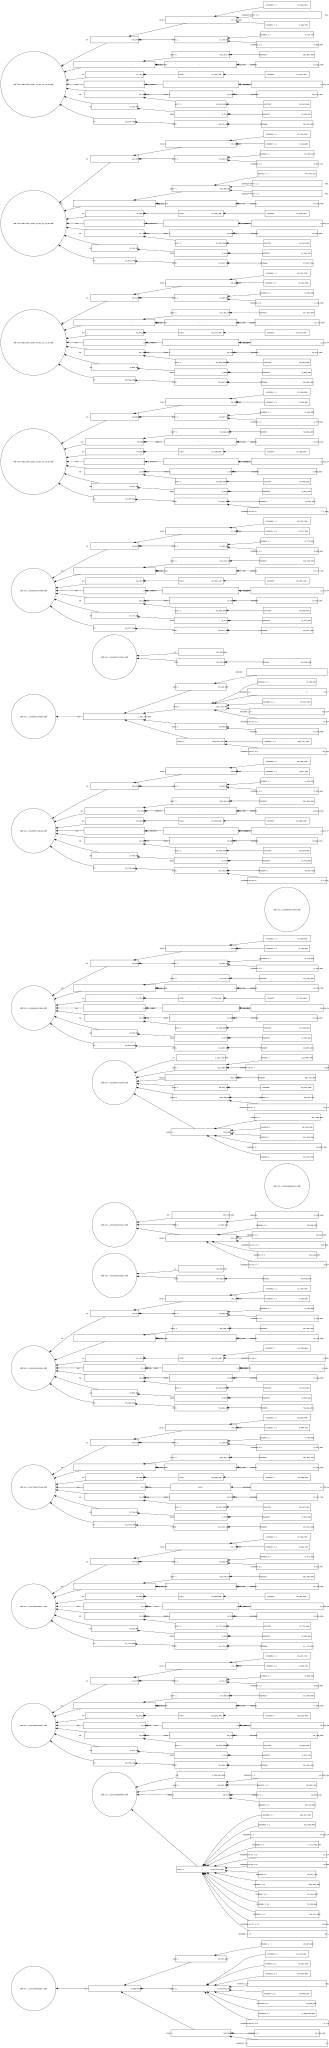

In [31]:
d

In [32]:
d.render('out',format='svg')

'out.svg'

In [33]:
bb_with_entry[bb_with_entry.pdf == 'pdf/62/A20181002170030.pdf']\
.groupby(['pagenum', 'line_label'])\
.apply(lambda x: print(x[['bullet_label', 'fix_text']].values.tolist()));

# Contruct table

In [34]:
doc_count = {}
for doc_name in document_index.values():
    doc_name = re.sub('\s','',doc_name)
    doc_count[doc_name] = doc_count.get(doc_name, 0) + 1
doc_names = [k for k, v in doc_count.items() if v > 3]

## Get department name

In [35]:
doc_org_name = {}
for pdf, pdf_df in bb_with_entry[(bb_with_entry.pagenum == 0)].groupby(['pdf',]):
    for l, line_df in pdf_df.groupby(['line_label']):
        line_text = line_df.fix_text.values.tolist()[0]
        if re.findall('[\u0E00-\u0E7F]+', line_text):
            print(pdf, line_text)
            doc_org_name[pdf] = line_text
            break

pdf/61/A20171003162813.pdf สำนักการคลัง
pdf/61/A20171003165217.pdf สำนักงานเขตบางคอแหลม
pdf/61/A20171003170128.pdf สำนักงานเขตบางแค
pdf/61/A20171005094804.pdf สำนักอนามัย
pdf/61/A20171005135427.pdf สำนักงานเขตวังทองหลาง
pdf/62/A20181002093131.pdf สารบัญ
pdf/62/A20181002152821.pdf สำนักงานเลขานุการสภากรุงเทพมหานคร
pdf/62/A20181002153512.pdf สำนักป้องกันและบรรเทาสาธารณภัย
pdf/62/A20181002180910.pdf สำนักงานเขตบึงกุ่ม
pdf/63/A20190917115231.pdf สำนักงานเลขานุการสภากรุงเทพมหานคร
pdf/63/A20190917115344.pdf สำนักปลัดกรุงเทพมหานคร
pdf/63/A20190917115953.pdf สำนักวัฒนธรรม
pdf/63/A20190917165155.pdf สำนักงานเขตปทุมวัน
pdf/63/A20190918113854.pdf สำนักงานเขตบางพลัด
pdf/63/A20190918113918.pdf สำนักงานเขตจอมทอง
pdf/63/A20190918114004.pdf สำนักงานเขตสวนหลวง
pdf/64/topic2787_2020_10_06_10_16_30.pdf สำนักงานเขตสัมพันธวงศ์
pdf/64/topic2787_2020_10_06_10_17_35.pdf สำนักงานเขตดอนเมือง
pdf/64/topic2787_2020_10_06_10_18_00.pdf สำนักงานเขตราชเทวี
pdf/64/topic2787_2020_10_06_10_18_03.pdf สำนักงานเขตคลองเตย


## structuring

In [37]:
rows = []
for c, p in child_parent_table.items():
    is_leaf = c not in child_parent_table.values()
    if not is_leaf: continue

    curr_p = p
    ancesters = []
    while curr_p is not None:
        ancesters.append(curr_p)
        curr_p = child_parent_table[curr_p]

    ancesters = ancesters[::-1]
    
    pdf_name = bb_with_entry[bb_with_entry.entry_label == c].pdf.iloc[0]
    org = doc_org_name[pdf_name]
    ancesters.append(c)
    entries = [entry_text_table.loc[a] for a in ancesters]

    temp_row = dict()
    for i, entry in enumerate(entries):
        amount = re.findall('([\d,]+) ?บาท', entry)
        entry = re.sub('[\d,]+ ?บาท', '', entry)
        
        bullet = re.findall('^[\d\.\-–]+',entry)
        entry = re.sub('^[\d\.\-–]+', '',entry)        
        entry = entry.strip()
        
        if not amount:
            print(entry)
        if i == len(entries) - 1:
            temp_row['output/proj'] = bullet[0]
            temp_row['output_proj_name'] = entry
            temp_row['amount'] = amount[0]
        else:
            temp_row[f'bullet_{i}'] = bullet[0]
            temp_row[f'name_{i}'] = entry
            if amount:
                temp_row[f'amount_{i}'] = amount[0]

    row = {'name_organization': org, 'pdf_name': pdf_name}
    row.update(temp_row)
    rows.append(row)

แผนงานจัดการระบายนำ และแก้ไขปัญหานำท่วม


In [39]:
pd.DataFrame(rows).to_csv('bkkbudget_61-64_v0.csv')